## Define channel order, module

In [0]:
%tensorflow_version 1.x
import tensorflow

TensorFlow 1.x selected.


In [0]:
import argparse

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras import backend as K


K.set_image_data_format('channels_first')

Using TensorFlow backend.


## Define Dataset

In [0]:
class Data:
    """
    Define dataset for training GAN
    """
    def __init__(self, batch_size, z_input_dim):
        # load mnist dataset
        # 이미지는 보통 -1~1 사이의 값으로 normalization : generator의 outputlayer를 tanh로
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        self.x_data = ((X_train.astype(np.float32) - 127.5) / 127.5)
        self.x_data = self.x_data.reshape((self.x_data.shape[0], 1) + self.x_data.shape[1:])
        self.batch_size = batch_size
        self.z_input_dim = z_input_dim

    def get_real_sample(self):
        """
        get real sample mnist images

        :return: batch_size number of mnist image data
        """
        return self.x_data[np.random.randint(0, self.x_data.shape[0], size=self.batch_size)]

    def get_z_sample(self, sample_size):
        """
        get z sample data

        :return: random z data (batch_size, z_input_dim) size
        """
        return np.random.uniform(-1.0, 1.0, (sample_size, self.z_input_dim))

- Mnist data test

In [0]:
data = Data(batch_size=2, z_input_dim=10)
print(data.get_real_sample())
print(data.get_z_sample(2))

11493376/11490434 [==============================] - 2s 0us/step
[[[[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]]


 [[[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]]]
[[-0.19036101 -0.0210851   0.5925117   0.68099112  0.29326307 -0.32307013
  -0.53249124  0.05762107  0.95129831  0.60187586]
 [-0.72401229  0.25772865  0.91707687 -0.04688654  0.74061352 -0.37662969
  -0.04513259  0.99460621 -0.53489132  0.1143693 ]]


## GAN 모델 정의

- discriminator : CNN 판별기로 모델링
- generator : input Z를 확장한 뒤 CNN 생성기로 모델링

In [0]:
class GAN:
    def __init__(self, learning_rate, z_input_dim):
        """
        init params

        :param learning_rate: learning rate of optimizer
        :param z_input_dim: input dim of z
        """
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.D = self.discriminator()
        self.G = self.generator()
        self.GD = self.combined()

    def discriminator(self):
        """
        define discriminator
        """
        D = Sequential()
        D.add(Conv2D(256, (5, 5),
                     padding='same',
                     input_shape=(1, 28, 28),
                     kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Conv2D(512, (5, 5), padding='same'))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Flatten())
        D.add(Dense(256))
        D.add(LeakyReLU(0.2))
        D.add(Dropout(0.3))
        D.add(Dense(1, activation='sigmoid'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return D

    def generator(self):
        """
        define generator
        """
        G = Sequential()
        G.add(Dense(512, input_dim=self.z_input_dim))
        G.add(LeakyReLU(0.2))
        G.add(Dense(128 * 7 * 7))
        G.add(LeakyReLU(0.2))
        G.add(BatchNormalization())
        G.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return G

    def combined(self):
        """
        defien combined gan model
        """
        G, D = self.G, self.D
        D.trainable = False
        GD = Sequential()
        GD.add(G)
        GD.add(D)

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        GD.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        D.trainable = True
        return GD


## Learner 구성

- discriminator와 generator를 다른 epoch 비율로 학습 가능하도록 구성
- 20 epoch 마다 이미지 생성
- D, G를 각각 학습
- 학습 완료 후 loss graph 생성

In [0]:
class Model:
    def __init__(self, batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.data = Data(self.batch_size, self.z_input_dim)

        # the reason why D, G differ in iter : Generator needs more training than Discriminator
        self.n_iter_D = n_iter_D
        self.n_iter_G = n_iter_G
        self.gan = GAN(self.learning_rate, self.z_input_dim)

        # print status
        batch_count = self.data.x_data.shape[0] / self.batch_size
        print('Epochs:', self.epochs)
        print('Batch size:', self.batch_size)
        print('Batches per epoch:', batch_count)
        print('Learning rate:', self.learning_rate)
        print('Image data format:', K.image_data_format())

    def fit(self):
        self.d_loss = []
        self.g_loss = []
        for epoch in range(self.epochs):

            # train discriminator by real data
            dloss = 0
            for iter in range(self.n_iter_D):
                dloss = self.train_D()

            # train GD by generated fake data
            gloss = 0
            for iter in range(self.n_iter_G):
                gloss = self.train_G()

            # save loss data
            self.d_loss.append(dloss)
            self.g_loss.append(gloss)

            # plot and save model each 20n epoch
            if epoch % 20 == 0:
                self.plot_generate_images(epoch, self.gan.G, examples=8)
                print('Epoch:', str(epoch))
                print('Discriminator loss:', str(dloss))
                print('Generator loss:', str(gloss))
        
        # show loss after train
        self.plot_loss_graph(self.g_loss, self.d_loss)

    def train_D(self):
        """
        train Discriminator
        """

        # Real data
        real = self.data.get_real_sample()

        # Generated data
        z = self.data.get_z_sample(self.batch_size)
        generated_images = self.gan.G.predict(z)

        # labeling and concat generated, real images
        x = np.concatenate((real, generated_images), axis=0)
        y = [0.9] * self.batch_size + [0] * self.batch_size

        # train discriminator
        self.gan.D.trainable = True
        loss = self.gan.D.train_on_batch(x, y)
        return loss

    def train_G(self):
        """
        train Generator
        """

        # Generated data
        z = self.data.get_z_sample(self.batch_size)

        # labeling
        y = [1] * self.batch_size

        # train generator
        self.gan.D.trainable = False
        loss = self.gan.GD.train_on_batch(z, y)
        return loss

    def plot_loss_graph(self, g_loss, d_loss):
        """
        Save training loss graph
        """

        # show loss graph
        plt.figure(figsize=(10, 8))
        plt.plot(d_loss, label='Discriminator loss')
        plt.plot(g_loss, label='Generator loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_generate_images(self, epoch, generator, examples=8):
        """
        Save generated mnist images
        """
        # plt info
        dim = (10, 10)
        figsize = (10, 10)

        # generate images
        z = self.data.get_z_sample(examples)
        generated_images = generator.predict(z)

        # show images
        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i].reshape((28, 28)), interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()


## 학습 진행

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epochs: 1000
Batch size: 128
Batches per epoch: 468.75
Learning rate: 0.0002
Image data format: channels_first



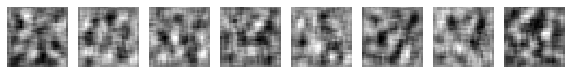

Epoch: 0
Discriminator loss: [0.6926503, 0.31640625]
Generator loss: [0.050842687, 1.0]


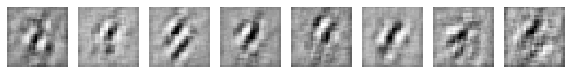

Epoch: 20
Discriminator loss: [0.34409234, 0.4921875]
Generator loss: [0.2371303, 1.0]


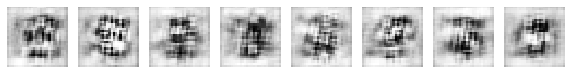

Epoch: 40
Discriminator loss: [0.85207886, 0.0]
Generator loss: [0.7268934, 0.421875]


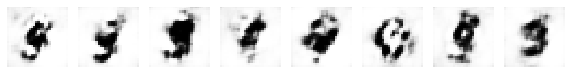

Epoch: 60
Discriminator loss: [0.5556865, 0.43359375]
Generator loss: [1.5050225, 0.09375]


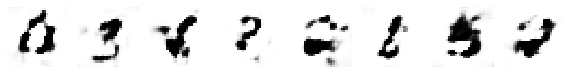

Epoch: 80
Discriminator loss: [0.6395513, 0.49609375]
Generator loss: [1.1001582, 0.0]


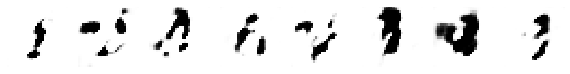

Epoch: 100
Discriminator loss: [0.56907713, 0.4140625]
Generator loss: [1.3493842, 0.015625]


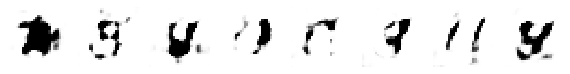

Epoch: 120
Discriminator loss: [0.4721203, 0.41015625]
Generator loss: [2.2297688, 0.0]


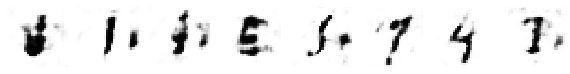

Epoch: 140
Discriminator loss: [0.58644307, 0.34765625]
Generator loss: [1.5259583, 0.03125]


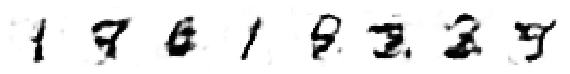

Epoch: 160
Discriminator loss: [0.6140641, 0.38671875]
Generator loss: [0.74819225, 0.4375]


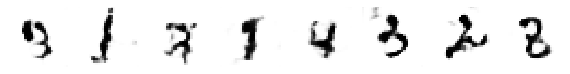

Epoch: 180
Discriminator loss: [0.8982762, 0.0]
Generator loss: [0.5579931, 0.8515625]


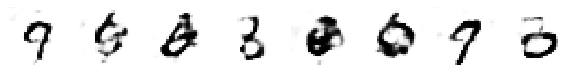

Epoch: 200
Discriminator loss: [0.59350204, 0.41796875]
Generator loss: [1.0051751, 0.125]


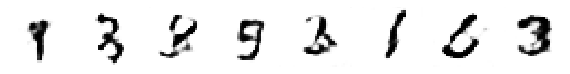

Epoch: 220
Discriminator loss: [0.6003715, 0.484375]
Generator loss: [0.799858, 0.390625]


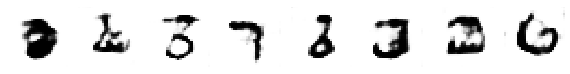

Epoch: 240
Discriminator loss: [0.7421335, 0.03125]
Generator loss: [1.7839347, 0.0]


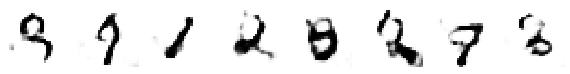

Epoch: 260
Discriminator loss: [0.71046, 0.06640625]
Generator loss: [1.2748406, 0.0078125]


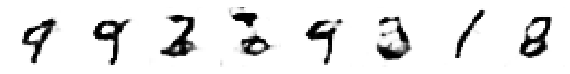

Epoch: 280
Discriminator loss: [0.61188877, 0.4375]
Generator loss: [0.8846384, 0.25]


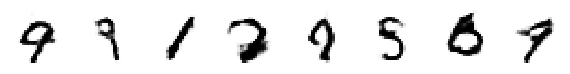

Epoch: 300
Discriminator loss: [0.76487595, 0.01171875]
Generator loss: [0.8030335, 0.2734375]


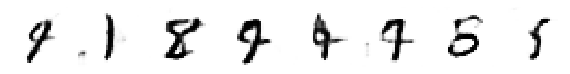

Epoch: 320
Discriminator loss: [0.641792, 0.4765625]
Generator loss: [0.7424952, 0.484375]


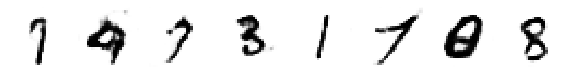

Epoch: 340
Discriminator loss: [0.6274384, 0.44921875]
Generator loss: [0.9410491, 0.078125]


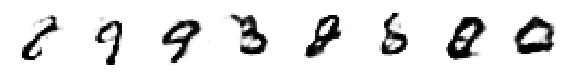

Epoch: 360
Discriminator loss: [0.65342784, 0.44921875]
Generator loss: [0.8061072, 0.3671875]


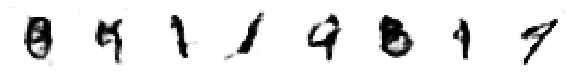

Epoch: 380
Discriminator loss: [0.63074887, 0.44140625]
Generator loss: [0.927528, 0.1875]


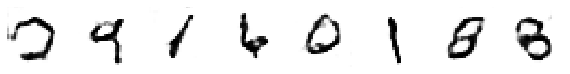

Epoch: 400
Discriminator loss: [0.6741516, 0.4765625]
Generator loss: [0.70095515, 0.484375]


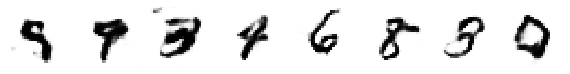

Epoch: 420
Discriminator loss: [0.6708247, 0.4609375]
Generator loss: [0.6844007, 0.53125]


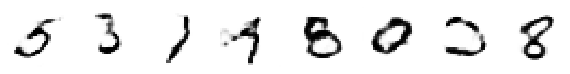

Epoch: 440
Discriminator loss: [0.70502275, 0.45703125]
Generator loss: [0.8230609, 0.2265625]


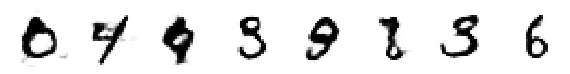

Epoch: 460
Discriminator loss: [0.6522825, 0.42578125]
Generator loss: [0.8855468, 0.21875]


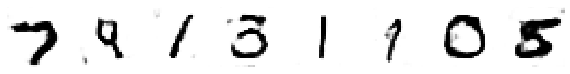

Epoch: 480
Discriminator loss: [0.65407014, 0.40625]
Generator loss: [0.8962002, 0.1484375]


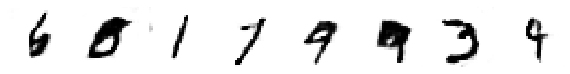

Epoch: 500
Discriminator loss: [0.65977734, 0.46484375]
Generator loss: [0.8256738, 0.2421875]


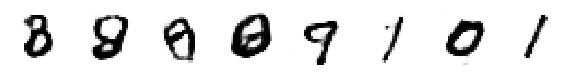

Epoch: 520
Discriminator loss: [0.66408336, 0.45703125]
Generator loss: [0.7225742, 0.5]


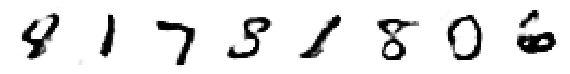

Epoch: 540
Discriminator loss: [0.6522498, 0.43359375]
Generator loss: [0.75894696, 0.390625]


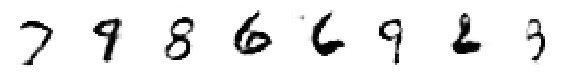

Epoch: 560
Discriminator loss: [0.6414392, 0.49609375]
Generator loss: [0.6033788, 0.75]


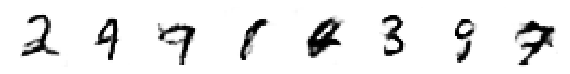

Epoch: 580
Discriminator loss: [0.6540424, 0.46875]
Generator loss: [0.8503749, 0.21875]


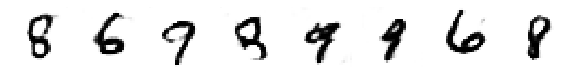

Epoch: 600
Discriminator loss: [0.66514534, 0.4140625]
Generator loss: [0.90727013, 0.109375]


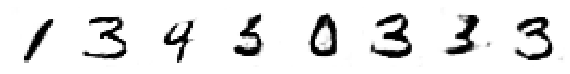

Epoch: 620
Discriminator loss: [0.6535007, 0.45703125]
Generator loss: [0.79432964, 0.28125]


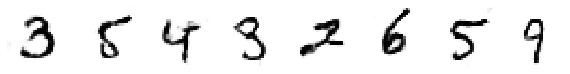

Epoch: 640
Discriminator loss: [0.6722412, 0.3828125]
Generator loss: [0.9998334, 0.109375]


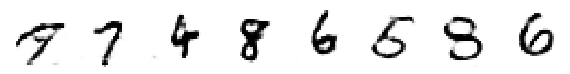

Epoch: 660
Discriminator loss: [0.65288544, 0.39453125]
Generator loss: [0.89448744, 0.1484375]


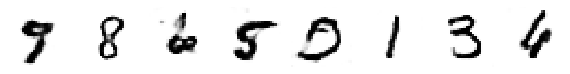

Epoch: 680
Discriminator loss: [0.64553887, 0.453125]
Generator loss: [0.87012964, 0.1875]


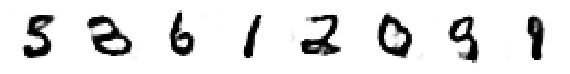

Epoch: 700
Discriminator loss: [0.6782507, 0.44921875]
Generator loss: [0.8204427, 0.265625]


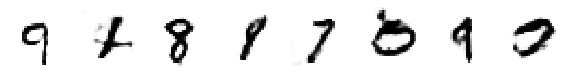

Epoch: 720
Discriminator loss: [0.68442154, 0.46484375]
Generator loss: [0.7680287, 0.3359375]


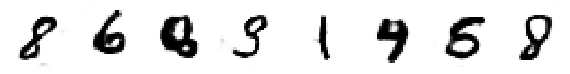

Epoch: 740
Discriminator loss: [0.65853244, 0.48828125]
Generator loss: [0.82726866, 0.2421875]


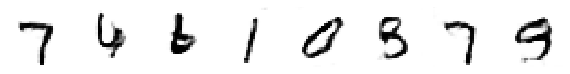

Epoch: 760
Discriminator loss: [0.64444983, 0.4296875]
Generator loss: [0.9822098, 0.1171875]


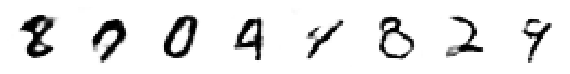

Epoch: 780
Discriminator loss: [0.6552433, 0.4140625]
Generator loss: [0.9696653, 0.046875]


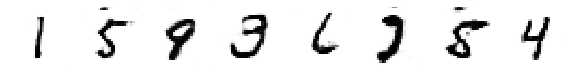

Epoch: 800
Discriminator loss: [0.6542148, 0.41796875]
Generator loss: [0.9147146, 0.15625]


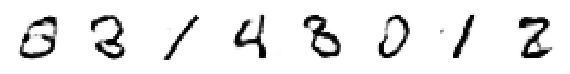

Epoch: 820
Discriminator loss: [0.6605494, 0.36328125]
Generator loss: [0.9099066, 0.1328125]


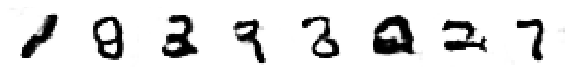

Epoch: 840
Discriminator loss: [0.63977355, 0.3828125]
Generator loss: [0.8741046, 0.2109375]


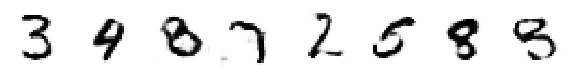

Epoch: 860
Discriminator loss: [0.64934605, 0.48046875]
Generator loss: [0.81925213, 0.265625]


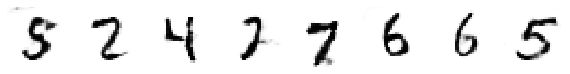

Epoch: 880
Discriminator loss: [0.6385122, 0.4296875]
Generator loss: [0.70227224, 0.515625]


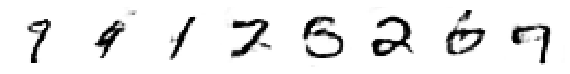

Epoch: 900
Discriminator loss: [0.6492449, 0.390625]
Generator loss: [0.97140396, 0.1953125]


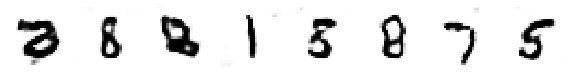

Epoch: 920
Discriminator loss: [0.6588488, 0.40234375]
Generator loss: [0.8664563, 0.140625]


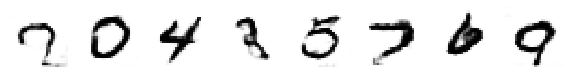

Epoch: 940
Discriminator loss: [0.66950697, 0.484375]
Generator loss: [0.8048315, 0.2578125]


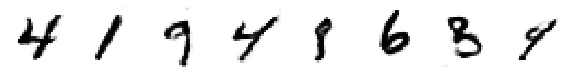

Epoch: 960
Discriminator loss: [0.6521452, 0.43359375]
Generator loss: [0.9268037, 0.1015625]


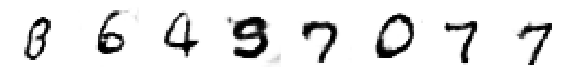

Epoch: 980
Discriminator loss: [0.6430122, 0.41796875]
Generator loss: [0.9897833, 0.140625]


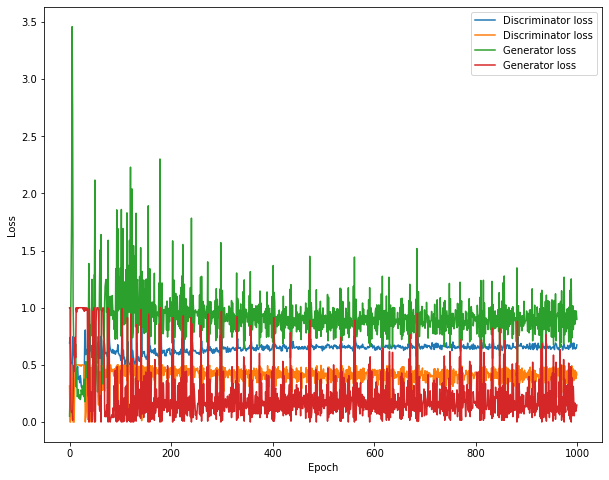

In [0]:
def main():
    # set hyper parameters    
    batch_size = 128
    epochs = 1000
    learning_rate = 0.0002
    z_input_dim = 100
    n_iter_D = 1
    n_iter_G = 5

    # run model
    model = Model(batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G)
    model.fit()


if __name__ == '__main__':
    main()

## 참고 : 모델 시각화

In [0]:
!apt-get install graphviz
!pip install -q pydot
!pip install graphviz


from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


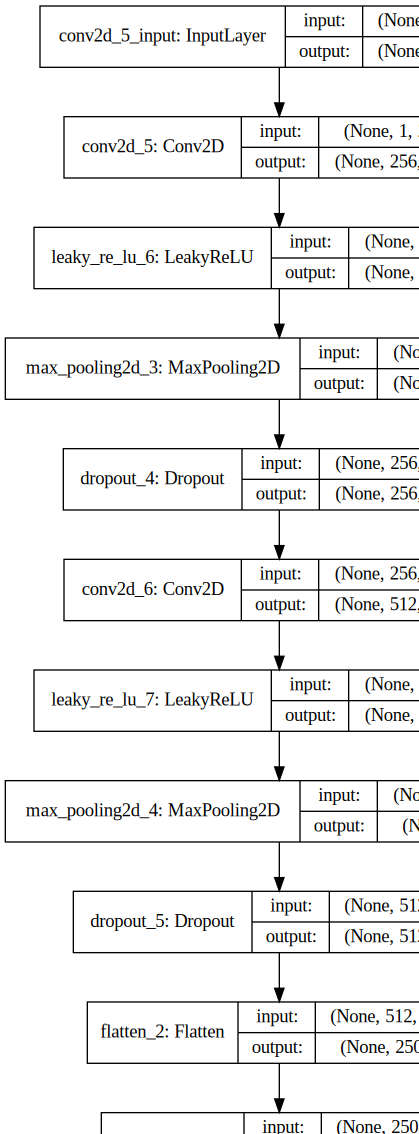

In [0]:
D = Sequential()
D.add(Conv2D(256, (5, 5),
         padding='same',
         input_shape=(1, 28, 28),
         kernel_initializer=initializers.RandomNormal(stddev=0.02)))
D.add(LeakyReLU(0.2))
D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
D.add(Dropout(0.3))
D.add(Conv2D(512, (5, 5), padding='same'))
D.add(LeakyReLU(0.2))
D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
D.add(Dropout(0.3))
D.add(Flatten())
D.add(Dense(256))
D.add(LeakyReLU(0.2))
D.add(Dropout(0.3))
D.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0002, beta_1=0.5)
D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

%matplotlib inline

SVG(model_to_dot(D, show_shapes=True).create(prog='dot', format='svg'))

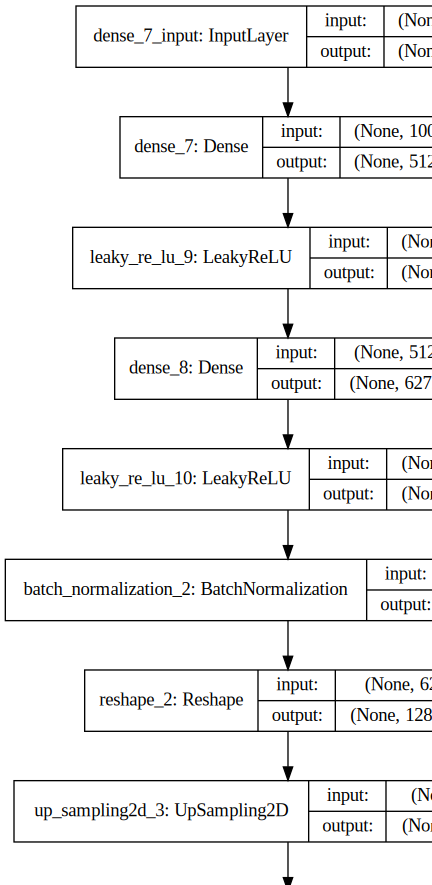

In [0]:
G = Sequential()
G.add(Dense(512, input_dim=100))
G.add(LeakyReLU(0.2))
G.add(Dense(128 * 7 * 7))
G.add(LeakyReLU(0.2))
G.add(BatchNormalization())
G.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

adam = Adam(lr=0.0002, beta_1=0.5)
G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

%matplotlib inline

SVG(model_to_dot(G, show_shapes=True).create(prog='dot', format='svg'))